# Exploring Dandiset 001375: Septum GABA Disruption with DREADDs

_This notebook was generated with the assistance of AI. Please use caution when interpreting the code or scientific results, and verify all analyses before drawing conclusions._

## Dandiset Overview

**Title**: Septum GABA disruption with DREADDs  
**Link**: [DANDI:001375, version 0.250406.1855](https://dandiarchive.org/dandiset/001375/0.250406.1855)

This Dandiset presents a pilot study exploring the effects of disrupting septal GABAergic activity in mice using DREADDs (Designer Receptors Exclusively Activated by Designer Drugs), with impacts on hippocampal and neocortical activity. The data includes high-density electrophysiology, spike sorting results, trial/behavior segmentation, and rich metadata.

## What This Notebook Covers

- Overview and inspection of NWB assets in the Dandiset
- Loading and verifying file structure and contents
- Visualization of:
    - Raw electrophysiological data
    - Spike rasters for all detected units
    - Electrode metadata table
    - Trial intervals
- All analyses are performed by streaming the NWB data remotely.

_The goal of this notebook is to help you begin your own exploration and reanalysis of this high-quality neuroscience dataset._

## Required Python Packages

- numpy
- pandas
- matplotlib
- h5py
- remfile
- pynwb
- dandi

(It is assumed these packages are already installed.)

## List NWB Assets in the Dandiset

We start by using the DANDI API to list all NWB files available in this Dandiset version.

In [1]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = "001375"
dandiset_version = "0.250406.1855"

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    nwb_assets = [asset.path for asset in dandiset.get_assets_by_glob("*.nwb")]

print("NWB files in Dandiset:")
for path in nwb_assets:
    print(path)

NWB files in Dandiset:
sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb
sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12781w8_ecephys.nwb
sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ardad2_ecephys.nwb


## Summary of NWB File: sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb

In this notebook, we focus on the file:

`sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb`

We will stream the file remotely using `remfile` and `h5py`, and load its main contents using `pynwb`.

In [2]:
import pynwb
import h5py
import remfile

nwb_path = "sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb"

# Find asset and get download URL
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(nwb_path))
    url = asset.download_url

# Open the NWB file remotely
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file, "r")
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### High-level Summary

Let's check high-level file and subject attributes, and the main groups/tables available in the NWB file.

In [3]:
print("NWB session description:", nwb.session_description)
print("Session start time:", nwb.session_start_time)
print("Subject ID:", nwb.subject.subject_id)
print("Subject description:", nwb.subject.description)
print("File identifier:", nwb.identifier)
print("\nMain available fields/groups:")
print("acquisition:", list(nwb.acquisition.keys()))
print("electrode_groups:", list(nwb.electrode_groups.keys()))
print("devices:", list(nwb.devices.keys()))
print("intervals:", list(nwb.intervals.keys()))
print("electrodes columns:", nwb.electrodes.colnames)
print("units columns:", nwb.units.colnames)
print("trials columns:", nwb.trials.colnames)

NWB session description: mouse running laps in virtual hallway
Session start time: 2024-07-25 19:00:00-07:00
Subject ID: MS13B
Subject description: medial septum DREADD to suppress GABA interneurons
File identifier: MS13B

Main available fields/groups:
acquisition: ['time_series']
electrode_groups: ['shank1', 'shank2']
devices: ['silicon probe array']
intervals: ['trials']
electrodes columns: ('x', 'y', 'location', 'filtering', 'group', 'group_name', 'label')
units columns: ('spike_times',)
trials columns: ('start_time', 'stop_time')


## Visualize a Segment of Raw Electrophysiological Data

Let's load and plot a brief 5-second segment from the first channel of the raw data to verify data format and quality.

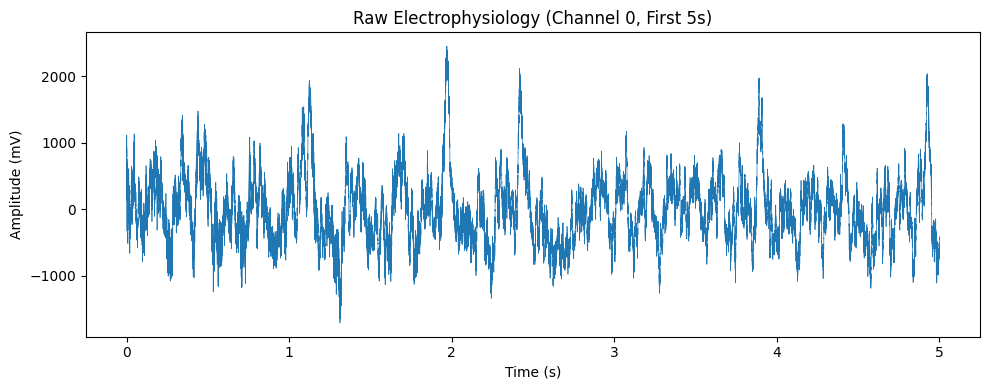

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Get acquisition parameters
ts = nwb.acquisition['time_series']
sample_rate = ts.rate
segment_seconds = 5
n_samples = int(segment_seconds * sample_rate)
channel_idx = 0  # Channel to plot

# Efficiently stream only the first n_samples for one channel
data_segment = ts.data[:n_samples, channel_idx]
time = (1 / sample_rate) * np.arange(n_samples)

# Convert units if necessary (should already be mV, but check for .conversion property)
conv = getattr(ts, "conversion", 1.0)
data_segment = data_segment * conv

plt.figure(figsize=(10, 4))
plt.plot(time, data_segment, lw=0.5)
plt.title(f'Raw Electrophysiology (Channel {channel_idx}, First {segment_seconds}s)')
plt.xlabel('Time (s)')
plt.ylabel(f'Amplitude ({ts.unit})')
plt.tight_layout()
plt.show()

## Visualize Spike Raster for All Units

Let's plot the spike raster for all detected units over the first 60 seconds of the session.

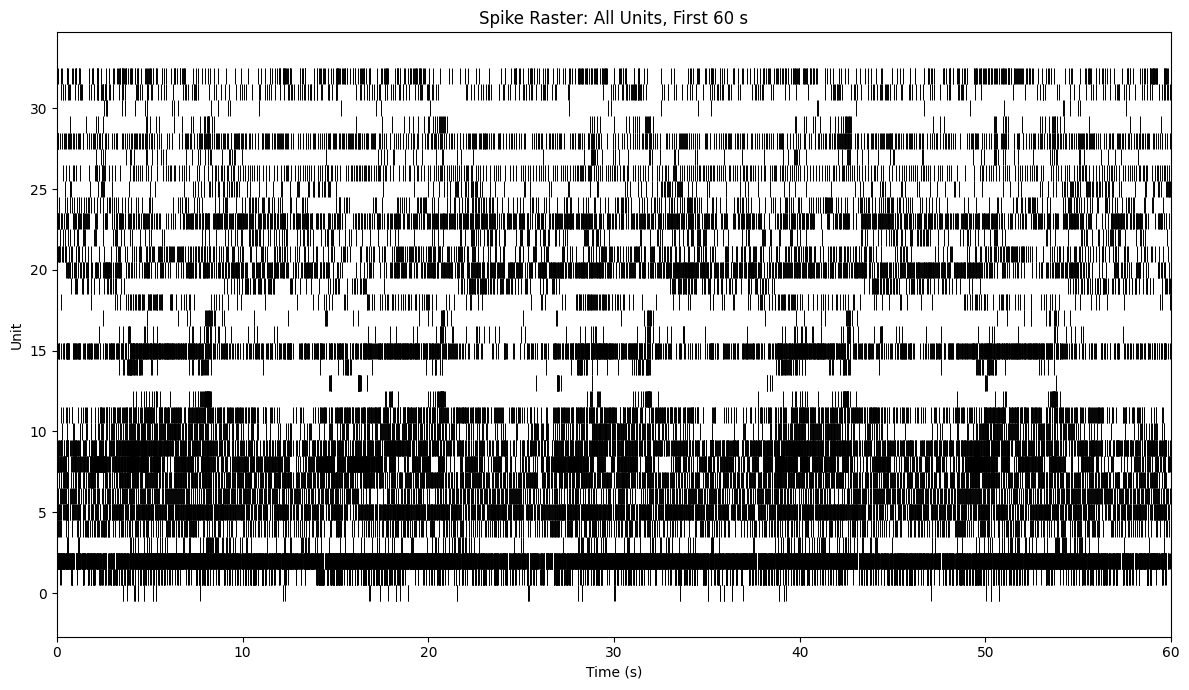

In [5]:
# Get spike times for all units using the NWB API's convenience
interval_seconds = 60
num_units = len(nwb.units)
raster_times = []
for i in range(num_units):
    spikes = nwb.units.spike_times_index[i]
    # Restrict spike times to the first 60 seconds
    spikes_in_window = spikes[(spikes >= 0) & (spikes < interval_seconds)]
    raster_times.append(spikes_in_window)

plt.figure(figsize=(12, 7))
plt.eventplot(raster_times, colors='k', linewidths=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Unit')
plt.title('Spike Raster: All Units, First 60 s')
plt.xlim(0, interval_seconds)
plt.tight_layout()
plt.show()

## Display Electrode Metadata Table

We now inspect the electrode metadata table, displaying `x`, `y`, `location`, `group`, and `label` columns for all 256 channels (showing the first few rows as an example).

In [6]:
import pandas as pd

columns_to_show = ['x', 'y', 'location', 'group', 'label']
electrodes_df = nwb.electrodes.to_dataframe()[columns_to_show]
pd.set_option("display.max_rows", 10)
display(electrodes_df)

,x,y,location,group,label
id,,,,,
0,20.0,1375.0,unknown,shank1 pynwb.ecephys.ElectrodeGroup at 0x13628...,shank1-electrode001
1,20.0,1325.0,unknown,shank1 pynwb.ecephys.ElectrodeGroup at 0x13628...,shank1-electrode002
2,20.0,1275.0,unknown,shank1 pynwb.ecephys.ElectrodeGroup at 0x13628...,shank1-electrode003
3,20.0,1225.0,unknown,shank1 pynwb.ecephys.ElectrodeGroup at 0x13628...,shank1-electrode004
4,20.0,1175.0,unknown,shank1 pynwb.ecephys.ElectrodeGroup at 0x13628...,shank1-electrode005
...,...,...,...,...,...
251,-20.0,1575.0,unknown,shank2 pynwb.ecephys.ElectrodeGroup at 0x13628...,shank2-electrode124
252,-20.0,1525.0,unknown,shank2 pynwb.ecephys.ElectrodeGroup at 0x13628...,shank2-electrode125
253,-20.0,1475.0,unknown,shank2 pynwb.ecephys.ElectrodeGroup at 0x13628...,shank2-electrode126


## Display Trial Table

We now inspect the behavioral trial intervals (start/stop times). Here are the first few rows:

In [7]:
trials_df = nwb.trials.to_dataframe()[['start_time', 'stop_time']]
print(trials_df.head())
print(f"... (total {len(trials_df)} trials)")

    start_time  stop_time
id                       
0     4.323800  16.929833
1    16.963067  28.414333
2    28.447100  39.402833
3    39.435833  50.027033
4    50.059667  63.064467
... (total 387 trials)


## Conclusion

In this notebook, we've:
- Explored and visualized the core data types in the DANDI:001375 dataset:
    - Raw electrophysiology
    - Spike-sorted unit times
    - Electrode metadata
    - Behavioral trials
- Streamed remote NWB files using `remfile`, ensuring efficient access without full downloads.

_Researchers can now build on this foundation for further reanalysis, such as detailed spike sorting QC, trial-based analyses, or custom signal processing. For additional files or more advanced analyses, repeat the steps above as needed._